## New Horizons MVIC ring calibration

The idea of this file is to do conversion between the DN limit seen by NH in the MVIC outbound ring images, and physical properties of the ring (such as I/F, tau, and equivalent width).

A few basic parameters of the MVIC outbound search (using `O_RINGDEP_MVICFRAME_305` as an example):
+ Ring opening angle (i.e., sub-observer latitude) = $43 \deg$
+ Date: P+110d = 2015-Nov-01
+ MVIC framing, 1x1, stacked
+ Phase angle $\phi = 165 \deg$
+ Total integration time: 30 sec/pixel (check this)
+ Region covered: 0 .. 105 $R_H$
+ Typical ring upper-limit signal: 0.03 DN per pixel

Various photometric equations and quantities. Not all of these are used here, but they are here for reference and completeness.
+ $\alpha$ = phase angle (forward = $180 \deg$).
+ $\theta$ = scattering angle (forward = $0 \deg$).
+ $P(\alpha)$ = particle phase function, computed from Mie scattering or otherwise. Normalized s.t. $\int_0^\pi P(\theta) \sin \theta d \theta = 2$. (TE98 eq 16).
+ $\tau$ = normal optical thickness.
+ $e$ = emission angle (measured from normal).
+ $B = 90-e$ = elevation angle (measured from equator). Same as sub-observer latitude.
+ $\mu$ = $\cos(e)$
+ $\varpi$ = single-scattering albedo.
+ $R$ = ring radius
+ `RSOLAR  = 100190.64   (DN/s)/(erg/cm^2/s/Ang/sr), Solar spectrum` -- calibration constant from MVIC FITS headers for extended sources (size > 1 pixel).
+ `I = DN / TEXP / RSOLAR = (DN/sec) / RSOLAR`, for I in erg/cm2/s/Ang/sr (NH ICD @ 62)
+ $I/F$ = normalized reflectance of the ring, where $I$ is measured at the detector, and $\pi F$ is the incident solar flux. (TPW04 @ 63)
+ $EW = \int {I\over F} dR$ -- Equivalent Width. Units of length.
+ $\left( {I \over F} \right)_{rad} = {EW \over {\Delta R}} = {1\over{\Delta R}}\int{I\over F} dR$.  Radially averaged normal $I/F$ of the ring (TE98 eq 12).
+ $4 \mu {I\over F} = \tau \varpi P(\alpha)$. This is the quantity we usually plot (TPW @ 63).
+ ${I\over F} = {{\tau \varpi P(\alpha)}\over {4 \mu}}$. Normal $I/F$ (i.e., I/F that would be measured from directly above the ring, with phase angle preserved). (TPW04 eq 1 @ 63)



The method here is this:
+ Measure DN upper-limit from the images.
+ Look up solar flux, and convert to flux at Pluto's distance.
+ Convert from DN to $I/F$ using the `RSOLAR` constant from the FITS header. We assume that the ring is spatially extended -- that is, it fills the pixels.
+ Use this to measure $\tau \varpi_0 P$.
+ Use this to get optical depth $\tau$.
+ Assume a phase function $P_{11}(\alpha)$ to get an optical depth $\tau$.

## Initialize settings and files

In [17]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy
from   astropy.io import fits
import math

dir = '/Users/throop/Data/NH_MVIC_Ring/'
file_ring = dir + 'ringdep_mos_v1_wcs_header_pl.fits' # This is Tod's mosaic image

d2r = 2*math.pi / 360.

# Define the typical brightness of the ring (upper-limit), in DN
dn_ring = 0.03

# Define the latitude of the observer. Usually we will look it up from SPICE.

lat_obs = 43.2  # Sub-observer latitude, in degrees

## Open file and read header

In [18]:
# Open file
hdulist = fits.open(file_ring)

# Read exposure parameters and constants from the FITS header

exptime      = float(hdulist['PRIMARY'].header['EXPTIME']) # Exposure time. This is per image (before stacking)
pixfov       = float(hdulist['PRIMARY'].header['PIXFOV'])# 19.8065   # Plate scale in microrad/pix
rsolar       = float(hdulist['PRIMARY'].header['RSOLAR']) # 100190.64. # (DN/s)/(erg/cm^2/s/Ang/sr)
                         # RSOLAR is conversion for solar spectrum. Use for resolved sources.    

## Define a function to convert DN to I/F

In [3]:
# Define DN → I/F conversion
def dn2iof(dn, exptime, pixfov, rsolar):

    # Calculate MVIC pixel size, in sr

    sr_pix       = (pixfov*(1e-6))**2  # Angular size of each MVIC pixel, in sr

    # Look up the solar flux at 1 AU, using the solar spectral irradiance at 
    #    http://rredc.nrel.gov/solar/spectra/am1.5/astmg173/astmg173.html
    # or http://www.pas.rochester.edu/~emamajek/AST453/AST453_stellarprops.pdf

    f_solar_1au_si     = 1.77                 # W/m2/nm. At 600 nm. 
    f_solar_1au_cgs    = f_solar_1au_si * 100 # Convert from W/m2/nm to erg/sec/cm2/Angstrom
                                              # Unit conversion is correct -- see python code below.

    f_solar_1au        = f_solar_1au_cgs

    # Calculate the solar flux at Pluto's distance. [Actual distance is 33.8 AU]

    f_solar_40au       = f_solar_1au / (33.8**2)  # Use 1/r^2, not 1/(4pi r^2)

    # Use constants (from Level-2 files) to convert from DN, to intensity at detector.

    # This is the equation in ICD @ 62.

    i_per_sr    = dn / exptime / rsolar # Convert into erg/cm2/s/sr/Angstrom.

    # Because the ring is spatially extended, it fills the pixel, so we multiply by pixel size
    # to get the full irradiance on the pixel.
    # *** But, somehow, this is not working. I get the right answer only if I ignore this 'per sr' factor.

    DO_OVERRIDE = True  # If true, ignore the missing factor of 'per sr' that seems to be in the conversion

    i           = i_per_sr * sr_pix     # Convert into erg/cm2/s/Angstrom

    if (DO_OVERRIDE):
        i = i_per_sr

    # Calculate "I/F". This is not simple the ratio of I over F, because F in the eq is not actually Flux.
    # "pi F is the incident solar flux density" -- ie, "F = solar flux density / pi"
    # SC93 @ 125

    iof = i / (f_solar_40au / math.pi)
    
    return iof


## Convert the ring DN into I/F

In [7]:
iof_ring = dn2iof(dn_ring, exptime, pixfov, rsolar)

# Now get optical depth, using equation I/F = tau omega P / (4 mu)

omega_0 = 0.3        # Single scattering albedo. Rough guess.
p11     = 10         # Phase function (normalized). This is a guess for forward-scattering.
                     # http://nit.colorado.edu/atoc5560/week8.pdf
                     # Or better: fig 4.8 of Wendisch & Yang book (from Google Books)

tau_ring = iof_ring * 4 * np.cos(lat_obs) / omega_0 / p11

In [8]:
print("Ring upper limit: DN = {:.3g}, I/F = {:.2g}, tau = {:.2g}.".format(dn_ring, iof_ring, tau_ring))
print(" Assuming omega_0 = {}, p11 = {}".format(omega_0, p11))

Ring upper limit: DN = 0.03, I/F = 6.1e-07, tau = 5.7e-07.
 Assuming omega_0 = 0.3, p11 = 10


## Now do a check of this conversion for a region of SP on Pluto

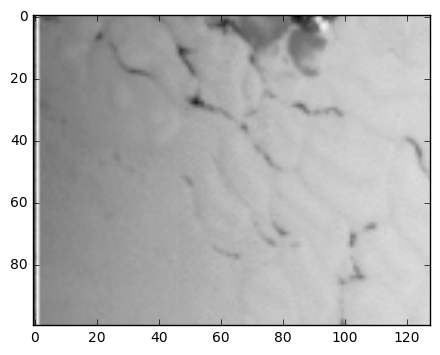

In [9]:
file = dir + 'mpf_0299175045_0x548_sci_1.fit'

hdu_sp = fits.open(file)
header = hdu_sp['PRIMARY'].header

exptime = float(header['EXPTIME'])
rpluto  = float(header['RPLUTO']) # (DN/s)/(erg/cm^2/s/Ang/sr), Pluto spectrum  
rsolar  = float(header['RSOLAR']) # (DN/s)/(erg/cm^2/s/Ang/sr), Solar spectrum 
ppluto  = float(header['PPLUTO'])
pixfov  = float(header['PIXFOV'])

im_sp = hdu_sp['PRIMARY'].data
im_spe = (np.transpose(im_sp[0,:,2700:2800]))  # Extract of SP image

plt.imshow(im_spe, cmap = 'Greys_r')
plt.show()

dn_sp = np.median(im_spe)  # Calculate the median value of this region of SP, in DN

iof_sp = dn2iof(dn_sp, exptime, pixfov, rpluto) # Convert from DN to I/F

iof_sp_known = 0.6 # From fig. 1F of Nature paper: max of (I/F)_sp ~ 0.6


In [12]:
print("Pluto surface: DN = {:.2f}, I/F = {:.2f}.".format(dn_sp, iof_sp))

Pluto surface: DN = 994.71, I/F = 0.42.


In [11]:
np.arange()

TypeError: Required argument 'start' (pos 1) not found